In [145]:
import jax
import jax.numpy as jnp 
from jax import random 
import equinox as eqx 
import optax
import matplotlib.pyplot as plt  

In [146]:
class NeuralNetwork(eqx.Module):
    layers: list

    def __init__(self, layer_sizes, key):
        self.layers = []

        for (fan_in, fan_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(fan_in, fan_out, use_bias=True, key=subkey)
            )
    
    def __call__(self, x):
        a = x
        for layer in self.layers[:-1]:
            a = jax.nn.sigmoid(layer(a))
        a = self.layers[-1](a)

        return a

def loss(model, x, target):
    output = jax.vmap(model)(x)
    return jnp.mean((target - output)**2)

def verifica_dados(x, y):
    print(f'x: {x.shape} y: {y.shape}')
    plt.scatter(x, y)
    plt.show()



x: (200, 1) y: (200, 1)


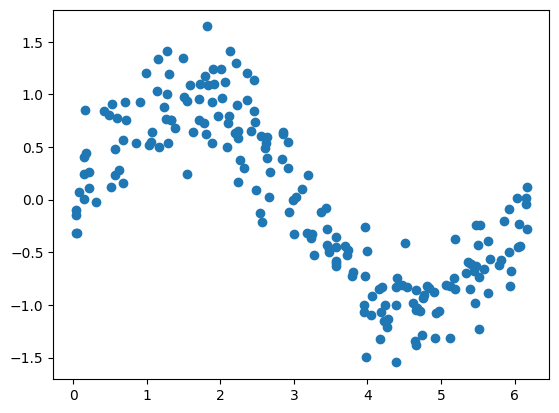

In [147]:
#OBTENÇÃO DOS DADOS
N_SAMPLES = 200
key = jax.random.PRNGKey(0)
key, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0., maxval=2*jnp.pi)
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.3

#INICIALIZÇÃO DA REDE NEURAL
LAYERS = [1, 180, 1]
model = NeuralNetwork(LAYERS, key)

#VERIFICAÇÃO DOS DADOS GERADOS
verifica_dados(x_samples, y_samples)

#verifica_dados(x_samples, y_samples)
loss_model = loss(model, x_samples, y_samples)
model_to_loss_and_grad = eqx.filter_value_and_grad(loss)

In [148]:
LEARNING_RATE = 1e-3
EPOCHS = 10000

optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

@eqx.filter_jit
def make_step(model, opt, input, target):
    loss, grad = model_to_loss_and_grad(model, input, target)
    updates, opt = optim.update(grad, opt, model)
    model = eqx.apply_updates(model, updates)
    return model, opt, loss

In [149]:
#TREINAMENTO
loss_history = []
for ep in range(EPOCHS):
    model, opt_state, loss = make_step(model, opt_state, x_samples, y_samples)
    loss_history.append(loss)

    if ep % 1000 == 0:
        print(f'Epoch: {ep}, loss: {loss}')

Epoch: 0, loss: 0.8535690307617188
Epoch: 1000, loss: 0.13978709280490875
Epoch: 2000, loss: 0.09330178797245026
Epoch: 3000, loss: 0.08029624819755554
Epoch: 4000, loss: 0.07905691117048264
Epoch: 5000, loss: 0.0788956806063652
Epoch: 6000, loss: 0.07873811572790146
Epoch: 7000, loss: 0.0785495862364769
Epoch: 8000, loss: 0.07827732712030411
Epoch: 9000, loss: 0.07796352356672287


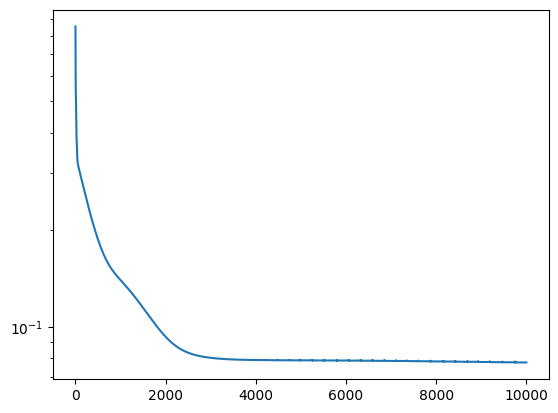

In [150]:
plt.plot(loss_history)
plt.yscale('log')

In [151]:
#jax.vmap(model)(x_samples).shape

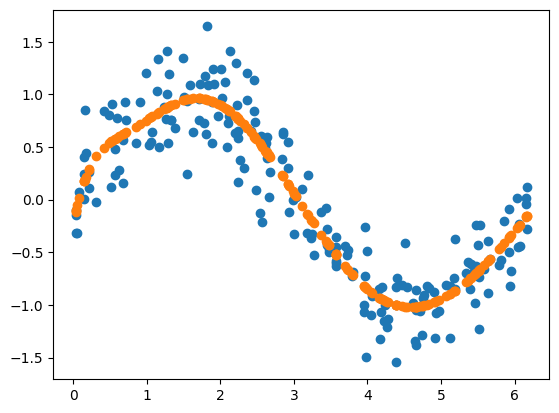

In [152]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, jax.vmap(model)(x_samples))